In [ ]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys

def estrai_traiettoria_da_bag(bag_path, topic="/odometry/filtered"):
    bag = rosbag.Bag(bag_path, 'r')
    xs, ys = [], []

    for _, msg, _ in bag.read_messages(topics=[topic]):
        # Estraggo posizione dal messaggio Odometry
        x = msg.pose.pose.position.x
        y = msg.pose.pose.position.y
        xs.append(x)
        ys.append(y)

    bag.close()
    return np.array(xs), np.array(ys)

def plotta_traiettoria_su_svg(svg_path, xs, ys, costmap_info, output_svg_path):
    """
    Plotta la traiettoria XY (in metri) sopra la heatmap SVG.
    costmap_info è dict con keys: 'resolution', 'origin_x', 'origin_y', 'width', 'height'
    Serve per convertire coordinate metri -> pixel immagine.
    """
    img = mpimg.imread(svg_path)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(img, origin='upper')

    # Trasformazione da coordinate metri a coordinate immagine (pixel)
    # pixel_x = (x - origin_x) / resolution
    # pixel_y = height - (y - origin_y) / resolution  (inversione Y per immagine)

    px = (xs - costmap_info['origin_x']) / costmap_info['resolution']
    py = costmap_info['width'] - (ys - costmap_info['origin_y']) / costmap_info['resolution']

    ax.plot(px, py, 'r-', linewidth=2, label='Traiettoria odometria')

    ax.axis('off')
    ax.legend()
    plt.title('Traiettoria sovrapposta alla costmap heatmap')

    plt.savefig(output_svg_path, format='svg')
    plt.close()
    print(f"Risultato salvato in: {output_svg_path}")



bagfile = "/mnt/data/anna/anna_ws/muro_2025-07-21-16-01-02.bag"
svgfile = "/mnt/data/anna/anna_ws/costmap_heatmap.png"
output_svg = "costmap_with_trajectory.svg"

# Parametri della costmap (dovresti inserirli correttamente)
costmap_info = {
    'resolution': 0.025,   # m/pixel, esempio
    'origin_x': -1.5,      # coordinate metri dell'origine costmap
    'origin_y': 5,
    'width': 200,         # dimensioni costmap in pixel (lunghezza griglia)
    'height': 200
}

xs, ys = estrai_traiettoria_da_bag(bagfile)
plotta_traiettoria_su_svg(svgfile, xs, ys, costmap_info, output_svg)


Risultato salvato in: costmap_with_trajectory.svg


In [ ]:
plt.figure(figsize=(12,6))
plt.boxplot([v_x, np.abs(w_z)], labels=['Linear X', 'Angular Z'])
plt.title('Boxplot velocità')
plt.ylabel('Valore')
plt.show()


In [ ]:
alpha = 0.8
sigma = 1.57
d = 2.3
d_safe = 0.5
s = np.cos(alpha)*np.sin(alpha)
lambda_ = 10*np.exp(-(d-d_safe)/0.7)
lambda_max = 10*np.exp(-(-d_safe)/0.7)
m = np.exp(-(alpha*alpha)/(2*sigma*sigma))

ang_vel = s*m*lambda_

print(f"m calcolato: {m:.4f}")
print(f"Lambda calcolato: {lambda_:.4f} m/s")
print(f"Velocità angolare calcolata: {ang_vel:.4f} rad/s")

vel_max = s*m*lambda_max
print(f"Velocità massima calcolata: {vel_max:.4f} m/s")

ang_vel_n = (2 * ((ang_vel - (-vel_max)) / (2 * vel_max)) - 1.0)
print(f"Velocità angolare normalizzata (-1,1): {ang_vel_n:.4f} rad/s")

In [ ]:
sigma = 1.57
d = 2.3
d_safe = 0.5
lambda_max = 10*np.exp(-(-d_safe)/0.7)
f = 0
for alpha in np.arange(0.0, 2*np.pi, np.pi/360):
    m = np.cos(alpha)*np.sin(alpha)*np.exp(-(alpha*alpha)/(2*sigma*sigma))
    f += np.abs(m)

vel_max = f*lambda_max
print(vel_max)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alphas = [np.arange(-np.pi/2, 0, np.pi/180)]
vel_max = 1
sigma = 2*np.pi/3
beta = np.pi/4
q = np.exp(-(beta*beta)/(2*sigma*sigma))
all = []
for alpha in alphas:
    m = np.cos(alpha)*np.sin(alpha)*np.exp(-(alpha*alpha)/(2*sigma*sigma))
    all.append(m)
all = np.array(all)
#all.squeeze()
v_ = np.array(all) * vel_max * 2/(q*len(alphas))
print(v_)

In [ ]:
#plot alphas
plt.figure(figsize=(10, 5))
plt.scatter(alphas[0], v_[0], label='v_ vs alphas')
plt.xlabel('Alpha')
plt.ylabel('velocity')
plt.title('Velocity vs Alpha')
plt.xlim(-np.pi/2, np.pi/2)
plt.ylim(-vel_max, vel_max)
plt.legend()
plt.show()

In [ ]:
np.sum(v_)/ len(alphas[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri iniziali
alpha = np.linspace(-np.pi, np.pi, 360)
distance = np.arange(0, 3.05, 0.05)  # fino a 3 incluso
sigma = [np.pi/6, np.pi/5, np.pi/4, np.pi/3, np.pi/2, 3*np.pi/4]
decay = 1.0
sigma0 = 2.0
sign = -1

max_velocity = 3.0
min_distance = 0.5


alpha0 = 0  # angolo fisso

# Scenario: 4 repulsori a destra
repellers_R = np.linspace(np.pi/8, 3*np.pi/8, 4)

omega_R = np.zeros_like(distance)

for ar in repellers_R:
    omega_R += sign*lambda_func(distance, min_distance, decay) * kernel(ar, sigma0)


# Normalizza
print("omega_R:", omega_R)
print(np.max(omega_R))
omega_R = max_velocity * omega_R / np.max(np.abs(omega_R))

# 3 repulsori a sinistra (angoli negativi)
repellers_L = np.linspace(-np.pi/2, -np.pi/8, 3)
omega_L = np.zeros_like(distance)

for ar in repellers_L:
    omega_L += lambda_func(distance, min_distance, decay) * kernel(alpha0 - ar, sigma0)


# Normalizza
omega_L = max_velocity * omega_L / np.max(np.abs(omega_L))

# ---------------------------------------------------
# Plot

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Subplot 1: kernel function con diversi sigma
ax = axs[0, 0]
for s in sigma:
    ax.plot(alpha, kernel(alpha, s), label=f'σ={s:.2f}')
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels(['-π', '-3π/4', '-π/2', '-π/4', '0',  'π/4','π/2', '3π/4', 'π'])
ax.set_title("Kernel function")
ax.set_xlabel('angle (rad)')
ax.grid(True)
ax.legend()

# Subplot 2: lambda function
ax = axs[0, 1]
ax.plot(distance, lambda_func(distance, min_distance, decay))
ax.set_ylim([0, 1.5])
ax.axvline(min_distance, color='k', linestyle='--')
ax.set_title("lambda function")
ax.set_ylabel('lambda value')
ax.grid(True)

# Subplot 3: Surface 3D plot
from mpl_toolkits.mplot3d import Axes3D  # necessario per 3D
ax = fig.add_subplot(2, 2, 3, projection='3d')

AA, DD = np.meshgrid(alpha, distance)
KK = kernel(AA, sigma0)
LL = lambda_func(DD, min_distance, decay)
VV = max_velocity * KK * LL

surf = ax.plot_surface(AA, DD, VV, cmap='turbo', linewidth=0, antialiased=True)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('distance (m)')
ax.set_zlabel('velocity (m/s)')
ax.set_title('3D Surface: V(α, d)')
ax.set_xticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels(['-π', '-3π/4', '-π/2', '-π/4', '0',  'π/4','π/2', '3π/4', 'π'])
fig.colorbar(surf, shrink=0.5, aspect=10)

# Subplot 4: confronto omega
ax = axs[1, 1]
ax.plot(distance, omega_R, 'r-', linewidth=2, label='Destra (α > 0)')
ax.plot(distance, omega_L, 'b--', linewidth=2, label='Sinistra (α < 0)')
ax.axhline(0, color='k', linestyle=':')
ax.axvline(min_distance, color='k', linestyle='--')
ax.set_xlabel('distance [m]')
ax.set_ylabel('ω(0, d) [rad/s]')
ax.set_title('Confronto ω(0, d) con 4 repulsori a destra o 3 a sinistra (v_max=3.0)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
vel_max_q = 3
sigma = 2*np.pi/3
strength = vel_max_q/kernel(np.pi/4, sigma)
d1 = 1.7
d2 = 1
d3 = 0.5
min_distance = 0.5
decay = 0.7

In [ ]:
alphas = np.arange(-np.pi/2, 0, np.pi/180)
w1 = sign*lambda_func(d1, min_distance, decay)*kernel(alphas, sigma)*strength
w2 = sign*lambda_func(d2, min_distance, decay)*kernel(alphas, sigma)*strength
w3 = sign*lambda_func(d3, min_distance, decay)*kernel(alphas, sigma)*strength
plt.plot(alphas, w1, label='d1=1.7')
plt.plot(alphas, w2, label='d2=1')
plt.plot(alphas, w3, label='d3=0.5')
plt.legend()

In [ ]:
sum_w1 = np.sum(w1)
sum_w2 = np.sum(w2)
sum_w3 = np.sum(w3)
print(sum_w1)
print(sum_w2)
print(sum_w3)

In [ ]:
aa = [np.pi/4, np.pi/3]

v = 0
for a in aa:
    v += sign*lambda_func(d1, min_distance, decay)*kernel(a, sigma)*strength

v_att = lambda_func(d1, min_distance, decay)*kernel(np.pi/4, sigma)*strength

print(v)
print(v_att)
v+v_att
#proposta 1: la velocità massima è quella in pi/4 a d=dmin.. non ha molto senso perche poi la somma dei vari contributi ti porta ad avere valori alti o comunque non sono così facili da controllare

In [ ]:
vel_max_ang = 0.1 #scelta da me
sign = -1
sigma = np.pi
alphas = np.arange(-np.pi/2, 0, np.pi/180)
epsilon = 0

strength_rep = vel_max_ang/(sign*(kernel(-np.pi/4, sigma))) #tale velocità angolare massima è data dai contributi provenienti da q1 e q2
strength_att = (vel_max_ang-epsilon)/kernel(np.pi/4, sigma)

print("strength rep: ", strength_rep, "att: ",strength_att  )

a = -np.pi/4
v1 = sign*lambda_func(min_distance, min_distance, decay)*kernel(a, sigma)*strength_rep

b = np.pi/3
v2 = lambda_func(min_distance, min_distance, decay)*kernel(b, sigma)*strength_att

c = np.pi/2
v3 = sign*lambda_func(min_distance, min_distance, decay)*kernel(c, sigma)*strength_rep


print(v1+v2+v3)
#perc = 1/(eps+np.abs(a-b))
#v_att = v_att-(v_att*perc/100)
np.min([1, v1+v2+v3])

#proposta 2: setto una vel max del quadrante equivalente alla velocità con quadrante pieno a d=dmin. 
#in questo modo la velocità finale so che varia tra -6 e 6 sempre in ogni quadrante. 
#il rapporto atttr-repulsori è 1:1. 
#si dovrebbe moltiplicare l'attrattore per un numero x e poi togliere potenza man mano che repulsori si aggiungono al suo stesso quadrante

In [ ]:
#proposta 3:
# decido che la velocità max del quadrante è vel_max_q e si raggiunge a d=dmin in pi/4
#per ogni quadrante estraggo il valore massimo dei repulsori e degli attrattori e mi assicuo che con tale valore la sedia riesca a sfuggire propriamente
#oi sommo attr e repulsore
#in questo modo la relazione è 1:1 e in campo ho al più 4 rep e 1 attr e in un singolo quadrante ho 1 e 1.
#a questo punto posso effettivamente decidere la finale relazione attr-rep ad esempio 0.9:1 ...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def setKmax(kmax_points, t_rad=np.pi/180, sigma=2*np.pi/3):
        
        step = (90/5)*t_rad
        kMax = 0
        kPoints = []
        pt = None
        for i in np.arange(-np.pi/2, 0, step): #avanza di step gradi
            max_k = 0
            
            for j in np.arange(0, step, t_rad):    #avanza di 1 grado 
                k = np.abs(kernel(i+j, sigma))
                if k > max_k:
                    max_k = k
                    pt = i+j
            
            kPoints.append(pt)
            kMax+= max_k


        kmax_points.append(kPoints)
        kPoints = []

        for i in np.arange(np.pi/2, np.pi, step):
            max_k = 0
            for j in np.arange(0, step, t_rad):
                k = np.abs(kernel(i+j, sigma))
                if k > max_k:
                    max_k = k
                    pt = i+j

            kPoints.append(pt)    
            kMax += max_k


        kmax_points.append(kPoints)
        return kMax


In [ ]:
points = []
sigma=2*np.pi/3
kmax = setKmax(points, np.pi/180, sigma)



In [ ]:
k_=0
for q in points:
    for pt in q:
        k_ += np.abs(kernel(pt, sigma))

print(k_)

In [ ]:
6 < np.inf

In [ ]:
#crea un vettore di 360 distanze random comprese tra 0.5 e 3 e con qualche valore a +infinito

polar_map = np.array([random.uniform(0.5, 3) for x in range(0, 360)])
t_rad=np.pi/180
step = 90/5
for i in np.arange(0, len(polar_map), step): 
            min_dist = np.inf
            index = 0
            for j in np.arange(step):
            
                d = polar_map[int(i+j)]
                if d <= min_dist:
                    if kernel(i+j, sigma) < kernel(index, sigma):
                     
                        continue
                  
                    min_dist = d
                    index = i+j

In [ ]:
def setKmax():
        t_rad = np.pi/180
        step = (360/20)*t_rad
        kMax = []
        for i in np.arange(0, np.pi/2, step): 
            max_k = 0
            for j in np.arange(0, step, t_rad):    
                k = np.abs(kernel(i+j, sigma))
                if k > max_k:
                    max_k = k
            
                
            kMax.append( max_k)

        for i in np.arange(-np.pi, -np.pi/2, step):
            
            max_k = 0
            for j in np.arange(0, step, t_rad):
                
                k = np.abs(kernel(i+j, sigma))
                if k > max_k:
                    max_k = k
                
            kMax.append(max_k)

        return kMax
#trovare i punti max di ogni quadrnte
#trovare kmax


In [ ]:
alphas = setKmax()
alphas = np.array(alphas)
d = [0.5, 0.5, 0.5, 0.5, 0.5]


v_ = 0
for i in np.arange(len(alphas)):
    m = kernel(alphas[i], sigma)*lambda_func(d[i], min_distance, decay)*-1
    v_+=(m)*20/(2*setKmax())

v_

In [ ]:
def setVelocity():
    omega_rep = 0
    for obj in ap_field:
        v = obj[2]*lambda_func(obj[1], min_distance, decay)*kernel(obj[0], sigma)
        v = (v*2*nsett)/kmax
        omega_rep+=v

    omega_attr = 0
    if(new_goal):
        omega_attr = lambda_func(obj[1], min_distance, decay)*kernel(obj[0], sigma)
        omega_attr = (delta*omega_attr*2*nsett)/kmax

    omega = omega_rep + omega_attr
    return omega


In [ ]:
#!/usr/bin/env python3

import rosbag
import numpy as np
import cv2

# === Parametri mappa ===
pgm_map = '/home/braingear/anna_ws/map.pgm'
resolution = 0.025
origin = (-13.3, 2.8)  # posizione nota di tag_1
invert_y = True
invert_x = True

# === Leggi immagine della mappa ===
map_img = cv2.imread(pgm_map, cv2.IMREAD_GRAYSCALE)

def world_to_map_coords(x_world, y_world):
    mx = int((x_world - origin[0]) / resolution)
    my = int((y_world - origin[1]) / resolution)
    if invert_y:
        my = map_img.shape[0] - my
    if invert_x:
        mx = map_img.shape[1] - mx
    return my, mx

# === Variabili ===
goals = []
odoms = []
odom_to_tag = None

# === Apri bag ===
bag = rosbag.Bag('/home/braingear/data/anna/2025-07-08-15-07-53.bag', 'r')

for topic, msg, t in bag.read_messages(topics=['goal', 'odometry/filtered', '/tf']):
    if topic == '/tf':
        for transform in msg.transforms:
            # Se troviamo la trasformazione odom -> tag_1, prendiamola solo la prima volta
            if transform.child_frame_id == 'tag_1' and transform.header.frame_id == 'odom':
                odom_to_tag = transform
    elif topic == '/goal' and odom_to_tag is not None:
        print('ok')
        pose = msg.pose
        dx = odom_to_tag.transform.translation.x
        dy = odom_to_tag.transform.translation.y
        x = pose.position.x + dx
        y = pose.position.y + dy
        goals.append((x, y))
    elif topic == '/odometry/filtered' and odom_to_tag is not None:
        print('ok')
        pose = msg.pose.pose
        dx = odom_to_tag.transform.translation.x
        dy = odom_to_tag.transform.translation.y
        x = pose.position.x + dx
        y = pose.position.y + dy
        odoms.append((x, y))

bag.close()

print(f"[INFO] Lettura completata: {len(goals)} goals, {len(odoms)} odometrie")

# === Converto in pixel ===
goal_pixels = [world_to_map_coords(x, y) for (x, y) in goals]
odom_pixels = [world_to_map_coords(x, y) for (x, y) in odoms]

# === Disegno ===
map_rgb = cv2.cvtColor(map_img, cv2.COLOR_GRAY2BGR)

for my, mx in goal_pixels:
    cv2.circle(map_rgb, (mx, my), 3, (0, 0, 255), -1)

for my, mx in odom_pixels:
    cv2.circle(map_rgb, (mx, my), 1, (255, 0, 0), -1)

cv2.imshow("Map with trajectories", map_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
#!/usr/bin/env python3

import rosbag
import numpy as np
import cv2

# === Parametri mappa ===
pgm_map = '/home/braingear/anna_ws/map.pgm'
resolution = 0.025
origin = (-13.3, 2.8)  # posizione nota di tag_1
invert_y = True
invert_x = True

# === Leggi immagine della mappa ===
map_img = cv2.imread(pgm_map, cv2.IMREAD_GRAYSCALE)

def world_to_map_coords(x_world, y_world):
    mx = int((x_world - origin[0]) / resolution)
    my = int((y_world - origin[1]) / resolution)
    if invert_y:
        my = map_img.shape[0] - my
    if invert_x:
        mx = map_img.shape[1] - mx
    return my, mx

# === Variabili ===
goals = []
odoms = []
odom_to_tag = None

# === Apri bag ===
bag = rosbag.Bag('/home/braingear/data/anna/2025-07-08-15-07-53.bag', 'r')

for topic, msg, t in bag.read_messages(topics=['goal', 'odometry/filtered']):
    print(topic)
    print(topic=="/tf")
    print(msg)

In [ ]:
import bagpy
from bagpy import bagreader
import pandas as pd

# === PARAMETRI ===
bag_file = '/home/braingear/data/anna/2025-07-11-12-33-52.bag'
topic = '/apf'


# === LEGGI DATI CON BAGPY ===
b = bagreader(bag_file)
apf_csv = b.message_by_topic(topic)
dfapf = pd.read_csv(apf_csv)

-2.4564015817034644e-05 x:  4.9 y:  4.9
-2.6208074756550373e-05 x:  4.9 y:  4.800000000000001
-2.773469323859505e-05 x:  4.9 y:  4.7
-2.909517046632686e-05 x:  4.9 y:  4.6000000000000005
-3.0238023941865733e-05 x:  4.9 y:  4.5
-3.111051175578018e-05 x:  4.9 y:  4.4
-3.166048712681574e-05 x:  4.9 y:  4.3
-3.183853546108637e-05 x:  4.9 y:  4.2
-3.160031369121295e-05 x:  4.9 y:  4.1000000000000005
-3.09089817737698e-05 x:  4.9 y:  4.0
-2.97375901456408e-05 x:  4.9 y:  3.9000000000000004
-2.8071268112028973e-05 x:  4.9 y:  3.8000000000000003
-2.590904987030003e-05 x:  4.9 y:  3.7
-2.3265179858040118e-05 x:  4.9 y:  3.6
-2.016975893724011e-05 x:  4.9 y:  3.5
-1.6668627650139643e-05 x:  4.9 y:  3.4000000000000004
-1.2822430682054261e-05 x:  4.9 y:  3.3000000000000003
-8.70486421009946e-06 x:  4.9 y:  3.2
-4.400169917639861e-06 x:  4.9 y:  3.1
-0.0 x:  4.9 y:  3.0
4.400169917639842e-06 x:  4.9 y:  2.9000000000000004
8.704864210099442e-06 x:  4.9 y:  2.8000000000000003
1.2822430682054243e-05 x

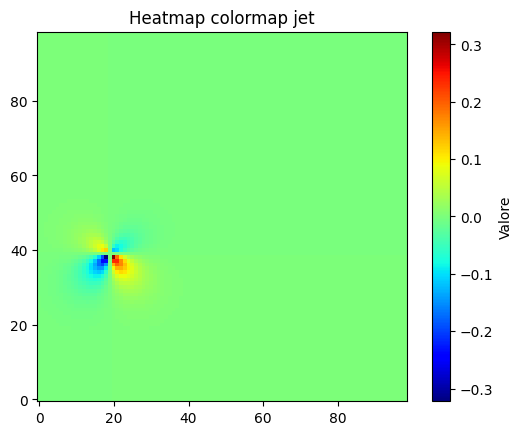

In [22]:
#[0,1,2,3,4,5,.....,95,96,97,98] = [-4.9, -4.8, -4.7, ..., 4.7, 4.8, 4.9] x
#[0,1,2,3,4,5,.....,95,96,97,98] = [-4.9, -4.8, -4.7, ..., 4.7, 4.8, 4.9] y
import numpy as np
import matplotlib.pyplot as plt
# Funzioni kernel e lambda
def kernel(a, s):
    return np.sin(a) * np.cos(a) * np.exp(- (a**2) / (2 * s**2))

def lambda_func(d, dmin, decay):
    return np.where(d < dmin, 1, np.exp(- (d - dmin) / decay))

objs = [[1, 3]]#,[1.2, 3],[1.4, 3],[1.6, 3],[1.8, 3],[1.4, -1]]#,[1.4, -1],[1.4, -1.3]]
sigma = 1.57
decay = 0.45

repulsori = np.zeros((99, 99))
for obj in objs:
    for i in np.arange(0, 99, 1):
        for j in np.arange(0, 99, 1):
            cell_x = -(i - 49)*0.1
            cell_y = -(j - 49)*0.1
            cell_obj_x = cell_x - obj[0]
            cell_obj_y = cell_y - obj[1]
            angle = np.atan2(cell_obj_y, cell_obj_x)
            distance = np.sqrt(cell_obj_x**2 + cell_obj_y**2)
            v = -1*kernel(angle, sigma)*lambda_func(distance, 0, decay)
            print(v, "x: ", cell_x, "y: ", cell_y)
            repulsori[i][j] += v
            #repulsori[i][j] = np.clip(repulsori[i][j], -0.360485, 0.360485)

plt.imshow(repulsori, cmap='jet', origin='lower')  # origin='lower' per avere l'origine in basso a sinistra
plt.colorbar(label='Valore')
plt.title("Heatmap colormap jet")
plt.show()



In [ ]:
repulsori[30][30]

In [ ]:
#[0,1,2,3,4,5,.....,95,96,97,98] = [-4.9, -4.8, -4.7, ..., 4.7, 4.8, 4.9] x
#[0,1,2,3,4,5,.....,95,96,97,98] = [-4.9, -4.8, -4.7, ..., 4.7, 4.8, 4.9] y

objs = [[1.4, -1]]#[[1, -3],[1.2, -3],[1.4, -3],[1.6, -3],[1.8, -3]]#,[1.4, -1],[1.4, -1.3]]
sigma = 1.57
decay = 0.7

matrice_xy = np.zeros((99, 99))
for obj in objs:
    for i in np.arange(0, 99, 1):
        for j in np.arange(0, 99, 1):
            cell_x = -(i - 49)*0.1
            cell_y = -(j - 49)*0.1
            cell_obj_x = cell_x - obj[0]
            cell_obj_y = cell_y - obj[1]
            angle = np.arctan2(cell_obj_y, cell_obj_x)
            distance = np.sqrt(cell_obj_x**2 + cell_obj_y**2)
            v = -1*kernel(angle, sigma)*lambda_func(distance, 0, decay)
            repulsori[i][j] += v
            repulsori[i][j] = np.clip(repulsori[i][j], -0.360485, 0.360485)

In [18]:
#[0,1,2,3,4,5,.....,95,96,97,98] = [-4.9, -4.8, -4.7, ..., 4.7, 4.8, 4.9] x
#[0,1,2,3,4,5,.....,95,96,97,98] = [-4.9, -4.8, -4.7, ..., 4.7, 4.8, 4.9] y

objs = [[1, -3],[1.2, -3],[1.4, -3],[1.6, -3],[1.8, -3]]#,[1.4, -1],[1.4, -1.3]]
sigma = 1.57
decay = 0.7

attrattori = np.zeros((99, 99))
for obj in objs:
    for i in np.arange(0, 99, 1):
        for j in np.arange(0, 99, 1):
            cell_x = -(i - 49)*0.1
            cell_y = -(j - 49)*0.1
            cell_obj_x = cell_x - obj[0]
            cell_obj_y = cell_y - obj[1]
            angle = np.arctan2(cell_obj_y, cell_obj_x)
            distance = np.sqrt(cell_obj_x**2 + cell_obj_y**2)
            v = 1*kernel(angle, sigma)*lambda_func(distance, 0, decay)
            attrattori[i][j] += v
            attrattori[i][j] = np.clip(attrattori[i][j], -0.360485, 0.360485)

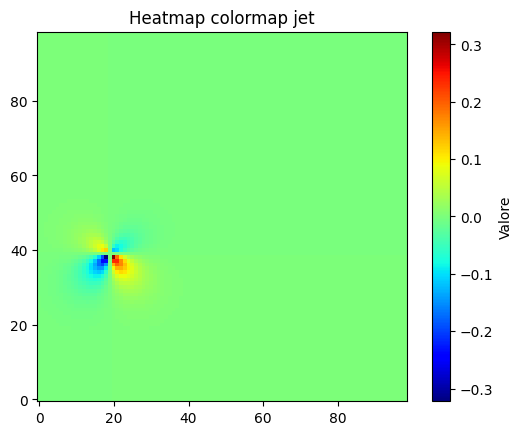

In [19]:
plt.imshow(repulsori, cmap='jet', origin='lower')  # origin='lower' per avere l'origine in basso a sinistra
plt.colorbar(label='Valore')
plt.title("Heatmap colormap jet")
plt.show()

In [ ]:
sum[30][49]

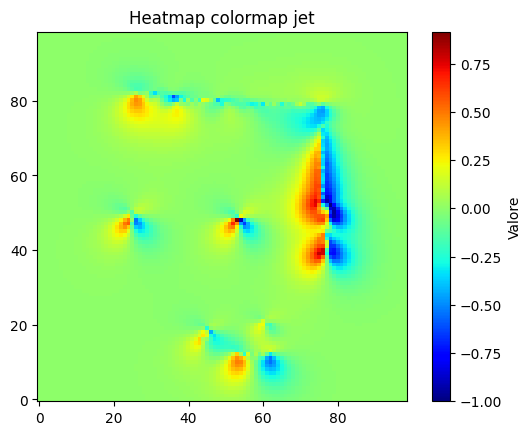

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Leggi la matrice dal file txt
# Supponiamo che sia separata da spazi, come l'output di Eigen
# Se usi CSV (con virgole), cambia delimiter=","
rep = np.loadtxt("/mnt/data/anna/anna_ws/matrice.csv", delimiter=",")


#repulsori = rep
# Visualizza l'immagine con colormap 'jet'
plt.imshow(np.fliplr(rep), cmap='jet', origin='lower')  # origin='lower' per avere l'origine in basso a sinistra
plt.colorbar(label='Valore')
plt.title("Heatmap colormap jet")
plt.show()


In [ ]:
sum = np.clip(attrattori + repulsori, -0.360485, 0.360485)
#sum = attrattori+repulsori
plt.imshow(sum, cmap='jet', origin='lower')  # origin='lower' per avere l'origine in basso a sinistra
plt.colorbar(label='Valore')
plt.title("Heatmap colormap jet")
plt.show()

In [ ]:
sum = attrattori+repulsori
plt.imshow(sum, cmap='jet', origin='lower')  # origin='lower' per avere l'origine in basso a sinistra
plt.colorbar(label='Valore')
plt.title("Heatmap colormap jet")
plt.show()

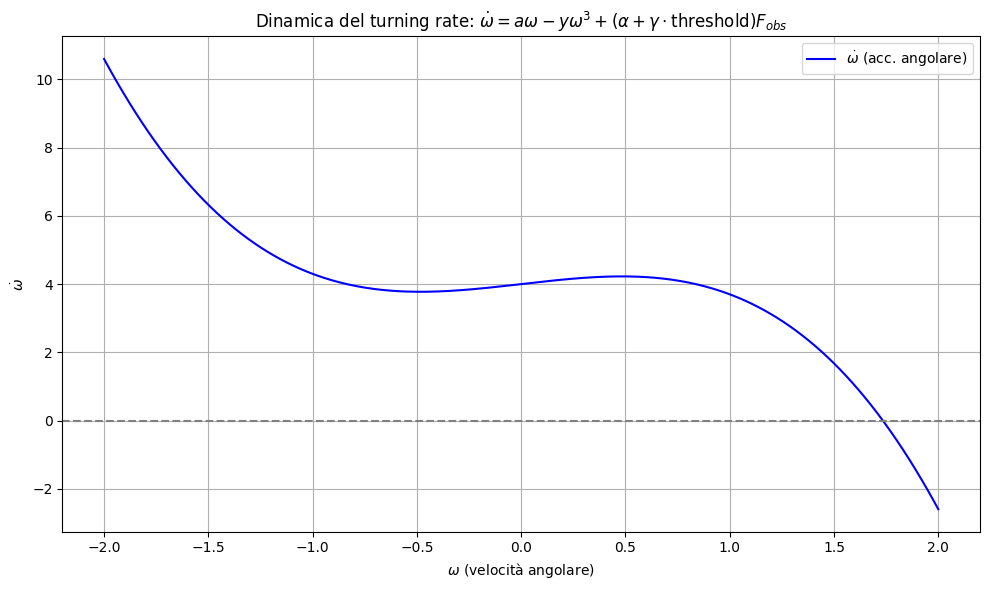

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri dinamici (puoi sperimentare con questi)
a = 0.7         # termine lineare (attrattore)
y = 1.0         # termine cubico (stabilizzazione)
alpha = 1.0     # guadagno base per Fobs
gamma = 1.0     # guadagno amplificato
threshold = lambda F: 1 if abs(F) > 0.2 else 0  # funzione a soglia

# Simula per un valore costante di Fobs
Fobs = 2  # forza repulsiva costante

# Range di omega (velocità angolare)
omega_vals = np.linspace(-2, 2, 400)

# Calcola dot_omega per ogni omega
dot_omega_vals = a * omega_vals - y * omega_vals**3 + (alpha + gamma * threshold(Fobs)) * Fobs

# Visualizzazione
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, dot_omega_vals, label=r'$\dot{\omega}$ (acc. angolare)', color='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.title(r'Dinamica del turning rate: $\dot{\omega} = a\omega - y\omega^3 + (\alpha + \gamma \cdot \text{threshold})F_{obs}$')
plt.xlabel(r'$\omega$ (velocità angolare)')
plt.ylabel(r'$\dot{\omega}$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Opening bag: /mnt/data/anna/anna_ws/2025-08-14-15-29-52.bag


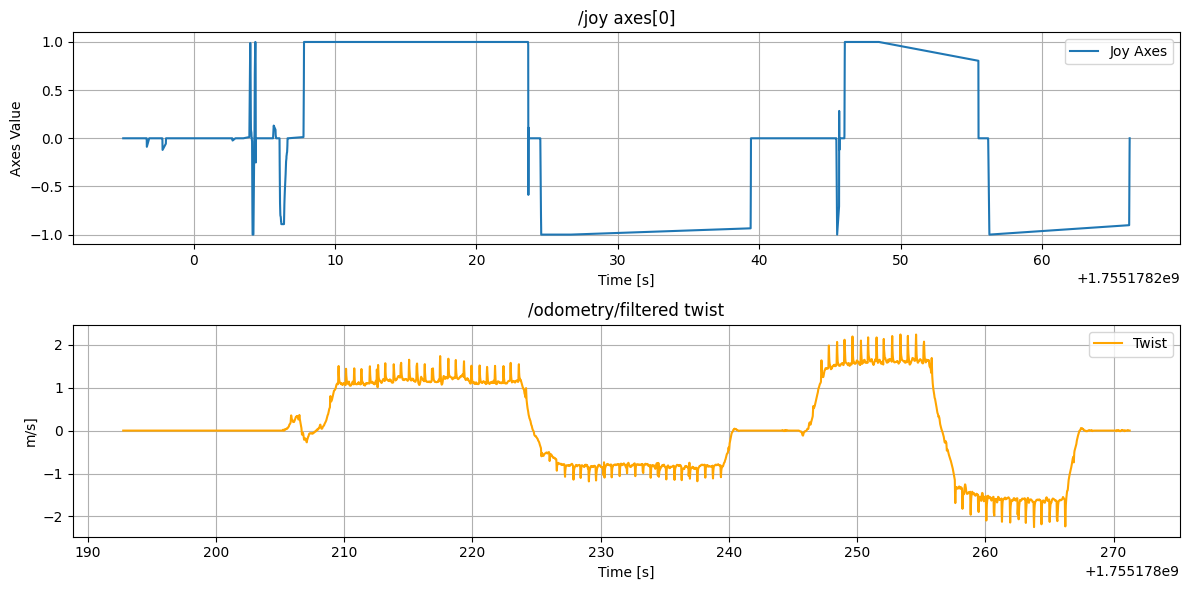

In [15]:
#!/usr/bin/env python

import rosbag
import matplotlib.pyplot as plt
from sensor_msgs.msg import Joy
from nav_msgs.msg import Odometry

def read_bag(bag_path):
    joy_times = []
    joy_axes_values = []

    odom_times = []
    odom_linear_x = []

    print(f"Opening bag: {bag_path}")
    with rosbag.Bag(bag_path, 'r') as bag:
        for topic, msg, t in bag.read_messages(topics=['/joy', '/odometry/filtered']):
            timestamp = t.to_sec()

            if topic == '/joy':
                if msg.axes:
                    joy_times.append(timestamp)
                    # Example: take the first axis (modify as needed)
                    joy_axes_values.append(msg.axes[0])
            elif topic == '/odometry/filtered':
                odom_times.append(timestamp)
                odom_linear_x.append(msg.twist.twist.angular.z)

    return (joy_times, joy_axes_values), (odom_times, odom_linear_x)

def plot_data(joy_data, odom_data):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(joy_data[0], joy_data[1], label='Joy Axes')
    plt.xlabel('Time [s]')
    plt.ylabel('Axes Value')
    plt.title('/joy axes[0]')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(odom_data[0], odom_data[1], color='orange', label='Twist')
    plt.xlabel('Time [s]')
    plt.ylabel('m/s]')
    plt.title('/odometry/filtered twist')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


bag_file = "/mnt/data/anna/anna_ws/2025-08-14-15-29-52.bag"  # Replace with your bag file path
joy_data, odom_data = read_bag(bag_file)
plot_data(joy_data, odom_data)
